In [1]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

from pandasgui import show

#

import warnings

In [2]:
warnings.filterwarnings( 'ignore' )

In [3]:
gmID_list = cfs.list_whitelisted_gmIDs()

In [4]:
topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [5]:
index = 0

test_chassis_df = cfs.retrieve_gmID_topic( gmID_list[ index ], '/apollo/canbus/chassis' )

test_best_pose_df = cfs.retrieve_gmID_topic( gmID_list[ index ], '/apollo/sensor/gnss/best/pose' )

In [6]:
test_chassis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53079 entries, 0 to 53078
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brakePercentage     53079 non-null  float64
 1   groupMetadataID     53079 non-null  object 
 2   drivingMode         53079 non-null  object 
 3   speedMps            53079 non-null  float64
 4   time                53079 non-null  int64  
 5   throttlePercentage  53079 non-null  float64
 6   steeringPercentage  53079 non-null  float64
 7   signal.turnSignal   53079 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 3.2+ MB


In [7]:
test_best_pose_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   heightMsl               1752 non-null   float64
 1   groupMetadataID         1752 non-null   object 
 2   latitudeStdDev          1752 non-null   float64
 3   longitude               1752 non-null   float64
 4   solType                 1752 non-null   object 
 5   extendedSolutionStatus  1752 non-null   int64  
 6   time                    1752 non-null   int64  
 7   heightStdDev            1752 non-null   float64
 8   solStatus               1752 non-null   object 
 9   latitude                1752 non-null   float64
 10  longitudeStdDev         1752 non-null   float64
 11  numSatsInSolution       1752 non-null   int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 164.4+ KB


In [8]:
variables = [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev' ]

disengagement_df_list = []

for gmID in gmID_list:

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df = chassis_df.sort_values( 'time' )

    best_pose_df = best_pose_df.sort_values( 'time' )

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.LatLonTotalStdDev( best_pose_df )

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    merged_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    merged_df = merged_df[ merged_df[ 'TernaryDrivingModeTransition' ] == -1 ]

    merged_df = merged_df[ variables ]

    disengagement_df_list.append( merged_df )

In [9]:
disengagement_df = pd.concat( disengagement_df_list )

In [11]:
disengagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2217 entries, 1561 to 23916
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brakePercentage     2217 non-null   float64
 1   speedMps            2217 non-null   float64
 2   throttlePercentage  2217 non-null   float64
 3   steeringPercentage  2217 non-null   float64
 4   LatLonTotalStdDev   2217 non-null   float64
dtypes: float64(5)
memory usage: 103.9 KB


In [12]:
speed_array = np.array( disengagement_df[ 'speedMps' ] )

steering_array = np.absnp.array( disengagement_df[ 'steeringPercentage' ] )

speed_array = ( speed_array - np.mean( speed_array ) ) / np.std( speed_array )

steering_array = ( steering_array - np.mean( steering_array ) ) / np.std( steering_array )

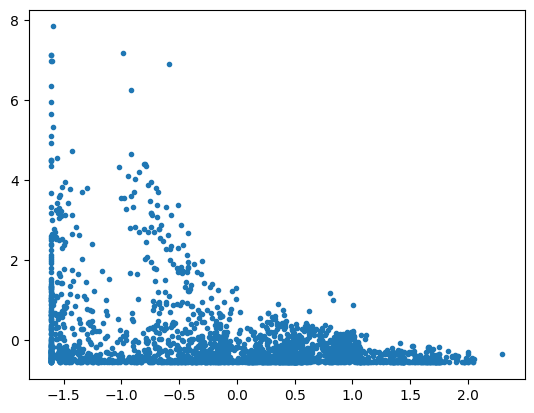

In [13]:
plt.plot( speed_array, steering_array, marker = '.', ls = '' )

In [14]:
def kmeans( df, k_num, initial_centroids = 'random', max_num_iterations = 100 ):

    points = []

    for index, row in df.iterrows():

        point = np.array( row )

        points.append( point )

    cols = []

    for col_name in df.columns:

        col = np.array( df[ col_name ] )

        cols.append( col )

    #

    col_means = np.array( [ np.mean( col ) for col in cols ] )

    col_stddevs = np.array( [ np.std( col ) for col in cols ] )

    points = [ ( point - col_means ) / col_stddevs for point in points ]

    cols = [ ( col - col_means[ col_num ] ) / col_stddevs[ col_num ] for col_num, col in enumerate( cols ) ]

    #

    centroids = []

    if ( type( initial_centroids ) == str ):

        for k_val in range( k_num ):

            centroid = np.array( [] )

            for col in cols:

                random_value = np.random.uniform( low = np.min( col ), high = np.max( col ) )

                centroid = np.append( centroid, random_value )

            centroids.append( centroid )

    else:

        for centroid in initial_centroids:

            centroid = ( centroid - col_means ) / col_stddevs

            centroids.append( centroid )

    initial_centroids = np.copy( centroids )

    #

    def euclidean_distance( point1, point2 ):

        p1p2_vector = point2 - point1

        p1p2_vector_magnitude = np.sqrt( np.sum( p1p2_vector * p1p2_vector ) )

        return p1p2_vector_magnitude

    def calculate_centroid( cluster ):

        sum_of_points = sum( cluster )

        num_of_points = len( cluster )

        mean_point = sum_of_points / num_of_points

        return mean_point
    #

    converged = False

    iteration = 0

    while ( ( converged == False ) and ( converged != 'Halted' ) ):

        clusters = [ [] for k_val in range( k_num ) ]

        for point in points:

            distance_to_centroid_array = np.array( [ euclidean_distance( point, centroid ) for centroid in centroids ] )

            k_val = np.argmin( distance_to_centroid_array )

            clusters[ k_val ].append( point )

        new_centroids = []

        for centroid, cluster in zip( centroids, clusters ):

            try:

                new_centroid = calculate_centroid( cluster )

            except:

                new_centroid = centroid

            new_centroids.append( new_centroid )

        iteration = iteration + 1

        bool_list = []

        for new_centroid, centroid in zip( new_centroids, centroids ):

            bool_list.append( new_centroid == centroid )

        if ( np.all( bool_list ) == True ):

            converged = True

        elif ( iteration == max_num_iterations ):

            converged = 'Halted'

        centroids = new_centroids

    #

    def cost( centroid, cluster ):

        cost_val = 0

        for point in cluster:

            point_centroid_vector = centroid - point

            squared_distance = np.sum( point_centroid_vector * point_centroid_vector )

            cost_val = cost_val + squared_distance

        return cost_val

    def total_cost( centroids, clusters ):

        total_cost_val = sum( [ cost( centroid, cluster ) for centroid, cluster in zip( centroids, clusters ) ] )

        return total_cost_val

    #

    def simplified_silhouette_coefficient( centroids, clusters ):

        simplified_silhouette_values = np.array( [] )

        for k_val_cluster, cluster in enumerate( clusters ):

            a_components = []

            b_components = [ [] for point in cluster ]

            for k_val_centroid, centroid in enumerate( centroids ):

                if ( k_val_centroid == k_val_cluster ):

                    for point in cluster:

                        a_components.append( euclidean_distance( point, centroid ) )

                else:

                    for index, point in enumerate( cluster ):

                        b_components[ index ].append( euclidean_distance( point, centroid ) )
                        
            a_components = np.array( a_components )

            b_components = np.array( [ min( distance_list ) for distance_list in b_components ] )

            for a_component, b_component in zip( a_components, b_components ):

                simplified_silhouette_value = ( b_component - a_component ) / max( ( a_component, b_component ) )

                simplified_silhouette_values = np.append( simplified_silhouette_values, simplified_silhouette_value )

        return np.mean( simplified_silhouette_values )

    #

    cost = total_cost( centroids, clusters )

    if ( k_num != 1 ):

        ssc = simplified_silhouette_coefficient( centroids, clusters )

    else:

        ssc = None

    if ( converged == True ):

        convergence_status = 'Converged'

    else:

        convergence_status = 'Halted'

    #

    for k_val_cluster, cluster in enumerate( clusters ):

        for index, point in enumerate( cluster ):

            clusters[ k_val_cluster ][ index ] = col_means + col_stddevs * point

    for k_val_centroid, centroid in enumerate( centroids ):

        centroids[ k_val_centroid ] = col_means + col_stddevs * centroid

    for k_val_centroid, centroid in enumerate( initial_centroids ):

        initial_centroids[ k_val_centroid ] = col_means + col_stddevs * centroid

    final_clusters = clusters

    final_centroids = centroids

    #

    return final_clusters, final_centroids, initial_centroids, cost, ssc, convergence_status

In [15]:
def find_max_ssc_k( df, k_num_range, num_iterations_for_each_k_num, max_num_iterations_for_kmeans = 100 ):

    lowest_k_num = k_num_range[ 0 ]

    highest_k_num = k_num_range[ 1 ]

    max_ssc_array = np.array( [] )

    for k_num in range( lowest_k_num, highest_k_num + 1 ):

        print( f'Current K_Num: { k_num }' )

        ssc_array = np.array( [] )

        for iteration in range( num_iterations_for_each_k_num ):

            _, _, _, _, ssc, _ = kmeans( df, k_num, max_num_iterations = max_num_iterations_for_kmeans )

            ssc_array = np.append( ssc_array, ssc )

        max_ssc_array = np.append( max_ssc_array, np.max( ssc_array ) )

    optimal_k_num = int( np.argmax( max_ssc_array ) ) + lowest_k_num

    return optimal_k_num

In [16]:
def find_min_cost_initial_centroids( df, k_num, num_iterations_to_minimize_cost, max_num_iterations_for_kmeans = 100 ):

    initial_centroids_list = []

    cost_array = np.array( [] )

    for iteration in range( num_iterations_to_minimize_cost ):

        _, _, initial_centroids, cost, _, _ = kmeans( df, k_num, max_num_iterations = max_num_iterations_for_kmeans )

        initial_centroids_list.append( initial_centroids )

        cost_array = np.append( cost_array, cost )

    min_cost_index = np.argmin( cost_array )

    min_cost_initial_centroids = initial_centroids_list[ min_cost_index ]

    return min_cost_initial_centroids

In [17]:
def make_elbow_plot( df, k_num_range, num_iterations_to_minimize_cost, max_num_iterations_for_kmeans = 100 ):

    lowest_k_num = k_num_range[ 0 ]

    highest_k_num = k_num_range[ 1 ]

    k_num_array = np.array( [ k_num for k_num in range( lowest_k_num, highest_k_num + 1 ) ] )

    min_cost_array = np.array( [] )

    for k_num in k_num_array:

        print( f'Current K_Num: { k_num }' )

        cost_array = np.array( [] )

        for iteration in range( num_iterations_to_minimize_cost ):

            _, _, _, cost, _, _ = kmeans( df, k_num, max_num_iterations = max_num_iterations_for_kmeans )

            cost_array = np.append( cost_array, cost )

        min_cost_array = np.append( min_cost_array, np.min( cost_array ) )

    plt.plot( k_num_array, min_cost_array, marker = '.' )

    plt.xlim( lowest_k_num - 1, highest_k_num + 1 )

    plt.xlabel( 'K-Num' )

    plt.ylabel( 'Cost' )

    plt.title( 'Elbow Plot' )

    plt.show()

In [369]:
# Testing

In [18]:
x1 = np.random.normal( 1, 0.3, 1000 )

x2 = np.random.normal( -1, 0.3, 1000 )

x3 = np.random.normal( 0, 0.3, 1000 )

x = np.append( x1, x2 )

x = np.append( x, x3 )

#

y1 = np.random.normal( 1, 0.3, 1000 )

y2 = np.random.normal( 1, 0.3, 1000 )

y3 = np.random.normal( -np.sqrt( 2 ), 0.3, 1000 )

y = np.append( y1, y2 )

y = np.append( y, y3 )

#

test_df = pd.DataFrame()

test_df[ 'x' ] = x

test_df[ 'y' ] = y

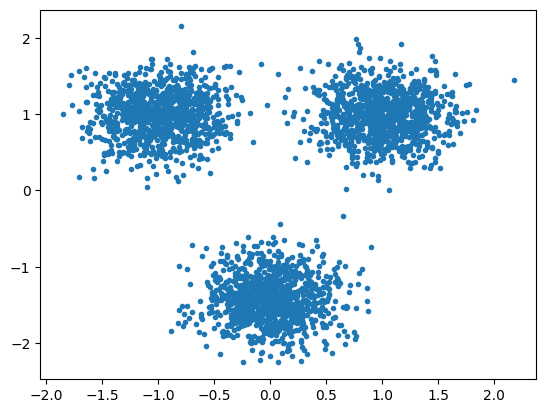

In [19]:
plt.plot( x, y, marker = '.', ls = '' )

plt.show()

Current K_Num: 1
Current K_Num: 2
Current K_Num: 3
Current K_Num: 4
Current K_Num: 5
Current K_Num: 6
Current K_Num: 7
Current K_Num: 8
Current K_Num: 9
Current K_Num: 10


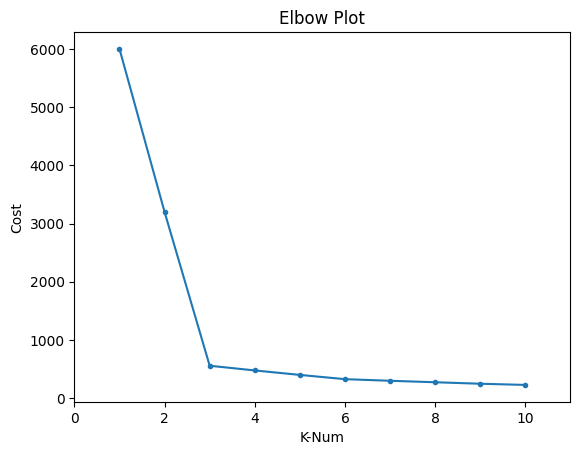

In [20]:
make_elbow_plot( test_df, ( 1, 10 ), 10 )

In [21]:
optimal_k_num = find_max_ssc_k( test_df, ( 2, 10 ), 10 )

print( optimal_k_num )

Current K_Num: 2
Current K_Num: 3
Current K_Num: 4
Current K_Num: 5
Current K_Num: 6
Current K_Num: 7
Current K_Num: 8
Current K_Num: 9
Current K_Num: 10
3


In [22]:
min_cost_initial_centroids = find_min_cost_initial_centroids( test_df, optimal_k_num, 25 )

In [24]:
final_clusters, final_centroids, initial_centroids, cost, ssc, convergence_status = kmeans( df = test_df,
                                                                                            k_num = optimal_k_num,
                                                                                            initial_centroids = min_cost_initial_centroids
                                                                                          )

In [25]:
print( f'SSC Value: { ssc }' )

print( '' )

col_names = list( disengagement_df.columns ) 

for cluster, centroid in zip( final_clusters, final_centroids ):

    print( f'Size: { len( cluster ) }' )

    for col_value, col_name in zip( centroid, col_names ):

        print( f'{ col_name }: { col_value }')

    print( '' )

SSC Value: 0.8231583094769367

Size: 1000
brakePercentage: 1.0034193902231934
speedMps: 0.9894058408624704

Size: 1000
brakePercentage: 0.0010265747166375377
speedMps: -1.4120523388564195

Size: 1000
brakePercentage: -0.9912106436819194
speedMps: 1.0002785628460955



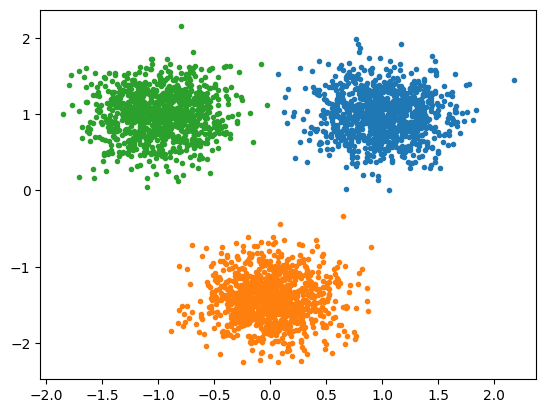

In [26]:
for cluster in final_clusters:

    list_of_arrays = []

    try:

        for index in range( len( cluster[ 0 ] ) ):

            array = np.array( [ point[ index ] for point in cluster ] )

            list_of_arrays.append( array )

        plt.plot( list_of_arrays[ 0 ], list_of_arrays[ 1 ], marker = '.', ls = '' )

    except:

        continue

plt.show()

In [286]:
# Applying

Current K_Num: 1
Current K_Num: 2
Current K_Num: 3
Current K_Num: 4
Current K_Num: 5
Current K_Num: 6
Current K_Num: 7
Current K_Num: 8
Current K_Num: 9
Current K_Num: 10


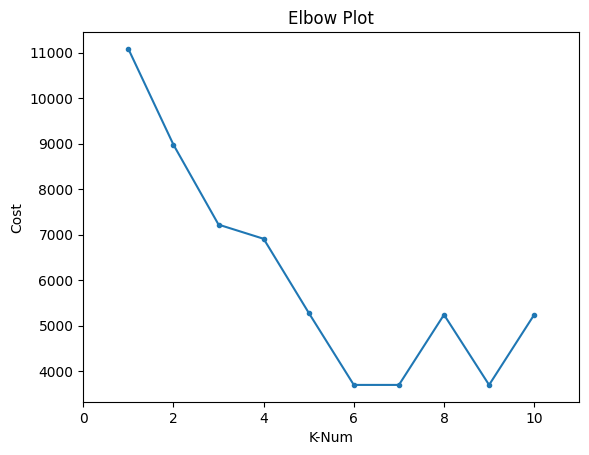

In [27]:
make_elbow_plot( disengagement_df, ( 1, 10 ), 100 )

In [28]:
optimal_k_num = find_max_ssc_k( disengagement_df, ( 2, 10 ), 100 )

print( optimal_k_num )

Current K_Num: 2
Current K_Num: 3
Current K_Num: 4
Current K_Num: 5
Current K_Num: 6
Current K_Num: 7
Current K_Num: 8
Current K_Num: 9
Current K_Num: 10
2


In [30]:
min_cost_initial_centroids = find_min_cost_initial_centroids( disengagement_df, optimal_k_num, 100 )

In [31]:
final_clusters, final_centroids, initial_centroids, cost, ssc, convergence_status = kmeans( df = disengagement_df,
                                                                                            k_num = optimal_k_num,
                                                                                            initial_centroids = min_cost_initial_centroids
                                                                                          )

In [32]:
print( f'SSC Value: { ssc }' )

print( '' )

col_names = list( disengagement_df.columns ) 

for cluster, centroid in zip( final_clusters, final_centroids ):

    print( f'Size: { len( cluster ) }' )

    for col_value, col_name in zip( centroid, col_names ):

        print( f'{ col_name }: { col_value }')

    print( '' )

SSC Value: 0.47986482774558414

Size: 1766
brakePercentage: 1.1672140430352123
speedMps: 12.590076966426953
throttlePercentage: 16.475764439411137
steeringPercentage: 4.917826740540771
LatLonTotalStdDev: 0.5736128900855725

Size: 451
brakePercentage: 30.809534368070974
speedMps: 8.87764102587583
throttlePercentage: 0.22195121951227392
steeringPercentage: 6.9011867718204005
LatLonTotalStdDev: 0.22036067393749603



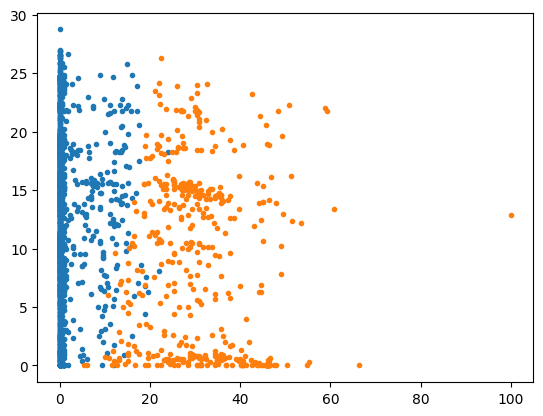

In [33]:
for cluster in final_clusters:

    list_of_arrays = []

    try:

        for col_num in range( len( cluster[ 0 ] ) ):

            array = np.array( [ point[ col_num ] for point in cluster ] )

            list_of_arrays.append( array )

        plt.plot( list_of_arrays[ 0 ], list_of_arrays[ 1 ], marker = '.', ls = '' )

    except:

        continue

plt.show()

In [415]:
final_clusters, final_centroids, initial_centroids, cost, ssc, convergence_status = kmeans( df = disengagement_df,
                                                                                            k_num = 4,
                                                                                            initial_centroids = min_cost_initial_centroids4
                                                                                          )

In [416]:
print( f'SSC Value: { ssc }' )

print( '' )

col_names = list( disengagement_df.columns ) 

for cluster, centroid in zip( final_clusters, final_centroids ):

    print( f'Size: { len( cluster ) }' )

    for col_value, col_name in zip( centroid, col_names ):

        print( f'{ col_name }: { col_value }')

    print( '' )

SSC Value: 0.4695678009575335

Size: 529
brakePercentage: 1.001890359168181
speedMps: 9.599208056975424
throttlePercentage: 47.07277882797733
steeringPercentage: 2.146952099782608
LatLonTotalStdDev: 0.34417172142916747

Size: 1456
brakePercentage: 8.741071428571425
speedMps: 14.040961682094782
throttlePercentage: 2.2013049450547353
steeringPercentage: 2.7872120704677164
LatLonTotalStdDev: 0.4900903689535766

Size: 231
brakePercentage: 11.685714285714285
speedMps: 3.054159108701299
throttlePercentage: 4.71731601731603
steeringPercentage: 28.57367659090908
LatLonTotalStdDev: 0.18694586298367882

Size: 1
brakePercentage: -8.881784197001252e-16
speedMps: 10.76
throttlePercentage: 0.0
steeringPercentage: 2.87953
LatLonTotalStdDev: 173.5601156552644



Cluster 1 Size: 529
Cluster 2 Size: 1456
Cluster 3 Size: 231
Cluster 4 Size: 1


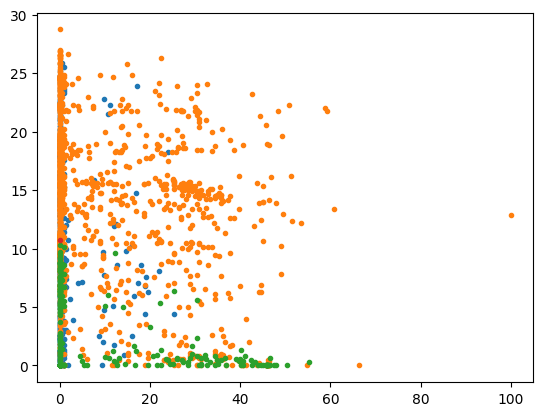

In [417]:
for cluster_num, cluster in enumerate( final_clusters ):

    print( f'Cluster { cluster_num + 1 } Size: { len( cluster ) }' )

    list_of_arrays = []

    try:

        for col_num in range( len( cluster[ 0 ] ) ):

            array = np.array( [ point[ col_num ] for point in cluster ] )

            list_of_arrays.append( array )

        plt.plot( list_of_arrays[ 0 ], list_of_arrays[ 1 ], marker = '.', ls = '' )

    except:

        continue

plt.show()

In [418]:
final_clusters, final_centroids, initial_centroids, cost, ssc, convergence_status = kmeans( df = disengagement_df,
                                                                                            k_num = 8,
                                                                                            initial_centroids = min_cost_initial_centroids8
                                                                                          )

In [419]:
print( f'SSC Value: { ssc }' )

print( '' )

col_names = list( disengagement_df.columns ) 

for cluster, centroid in zip( final_clusters, final_centroids ):

    print( f'Size: { len( cluster ) }' )

    for col_value, col_name in zip( centroid, col_names ):

        print( f'{ col_name }: { col_value }')

    print( '' )

SSC Value: 0.4665759823548598

Size: 384
brakePercentage: 19.304166666666628
speedMps: 3.2326989637500105
throttlePercentage: 2.9901041666667236
steeringPercentage: 18.705379139919273
LatLonTotalStdDev: 0.2528631884209613

Size: 515
brakePercentage: 1.029320388349455
speedMps: 9.271776592815531
throttlePercentage: 47.4190291262136
steeringPercentage: 2.1451373177223307
LatLonTotalStdDev: 0.26798489218097904

Size: 1
brakePercentage: -8.881784197001252e-16
speedMps: 10.76
throttlePercentage: 0.0
steeringPercentage: 2.87953
LatLonTotalStdDev: 173.5601156552644

Size: 0
brakePercentage: 65.91994851252811
speedMps: 16.083276722375892
throttlePercentage: 70.51324308451348
steeringPercentage: 73.06557562766672
LatLonTotalStdDev: 109.30381124100123

Size: 1313
brakePercentage: 6.103198781416612
speedMps: 15.361211483625283
throttlePercentage: 2.741812642802655
steeringPercentage: 2.6576991882482814
LatLonTotalStdDev: 0.42374742199626436

Size: 4
brakePercentage: -8.881784197001252e-16
speedMp